Installing missing package: scikit-learn ...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Installing missing package: sentence-transformers ...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


NLU path resolved to: /Users/siyunhe/Desktop/neu/capstone/capstone_mvp/nlu.py
[NLU] Initial intent: RAG (confidence: 0.752)
[NLU] Informational keywords detected → intent=RAG
[NLU] Final intent: RAG
[NLU] Domain: mowing
[NLU] Extracted slots: {'domain': 'mowing', 'month': None, 'year': None, 'start_month': None, 'end_month': None, 'range_year': None, 'park_name': None, 'image_uri': None, 'explanation_requested': False}
[NLU] Initial intent: RAG (confidence: 0.304)
[NLU] Low confidence (0.304) → fallback to RAG
[NLU] Final intent: RAG
[NLU] Domain: generic
[NLU] Extracted slots: {'domain': 'generic', 'month': None, 'year': None, 'start_month': None, 'end_month': None, 'range_year': None, 'park_name': None, 'image_uri': None, 'explanation_requested': False}
[NLU] Initial intent: RAG (confidence: 0.649)
[NLU] Informational keywords detected → intent=RAG
[NLU] Final intent: RAG
[NLU] Domain: mowing
[NLU] Extracted slots: {'domain': 'mowing', 'month': None, 'year': None, 'start_month': None

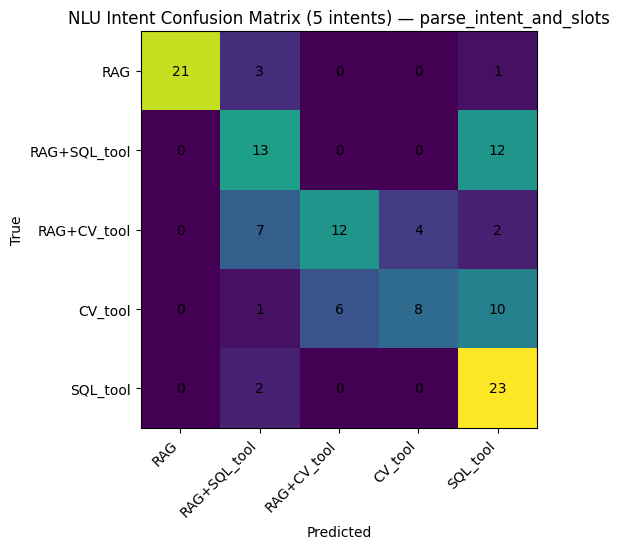

Saved: nlu_eval_dataset_strict.csv, nlu_eval_misclassified_strict.csv


In [ ]:
# === Strict NLU Intent Evaluation (no heuristics) ===
# Evaluate 5 classes: RAG, RAG+SQL_tool, RAG+CV_tool, CV_tool, SQL_tool

# --- Auto-install required packages if missing ---
import importlib
import subprocess
import sys

required_packages = [
    "numpy",
    "pandas",
    "scikit-learn",
    "matplotlib",
    "sentence-transformers"  # not used here directly but required by nlu.py
]

for pkg in required_packages:
    try:
        importlib.import_module(pkg)
    except ImportError:
        print(f"Installing missing package: {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# --- Imports (after ensuring they exist) ---
from pathlib import Path
from typing import Optional
import importlib.util
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

INTENTS = ["RAG", "RAG+SQL_tool", "RAG+CV_tool", "CV_tool", "SQL_tool"]

def synthesize_examples() -> pd.DataFrame:
    """
    Generate 10 test examples per intent.
    Each query is semantically close to the few-shot prototypes in nlu.INTENT_PROTOTYPES
    but phrased differently to avoid overlap.
    """
    data = []

    # --- RAG: textual guidance / procedures / standards ---
    rag_queries = [
        "Describe the correct process for trimming park lawns.",
        "How should mowing blades be adjusted for safety?",
        "What are the basic turf maintenance rules for summer?",
        "Give me the official mowing protocol for public fields.",
        "Outline how to prepare turf before large events.",
        "Explain how to safely refuel and clean a mower.",
        "List inspection steps before operating mowing equipment.",
        "What is the standard grass height for soccer practice areas?",
        "How often should turf be aerated under heavy use?",
        "Summarize recommended post-mowing cleanup procedures.",
    ]
    for q in rag_queries:
        data.append({"text": q, "image_uri": None, "label": "RAG"})

    # --- SQL_tool: structured queries only (no interpretation) ---
    sql_queries = [
        "Show total mowing cost by park for Q2 2025.",
        "Give me average mowing hours per week this May.",
        "List top 10 parks by irrigation repair cost.",
        "Display mowing frequency by park for July.",
        "Fetch the park with the lowest mowing expense in April.",
        "Return number of mowing operations completed last month.",
        "Provide total maintenance cost for June 2025 as a table.",
        "Show ranking of parks by total mowing labor hours.",
        "Get monthly mowing expenses for each district.",
        "List mean and median mowing cost per park this quarter.",
    ]
    for q in sql_queries:
        data.append({"text": q, "image_uri": None, "label": "SQL_tool"})

    # --- RAG+SQL_tool: data + interpretation grounded in standards/policy ---
    rag_sql_queries = [
        "Interpret why mowing expenses increased in April compared to March using mowing policies.",
        "Explain cost variation across parks based on mowing interval recommendations.",
        "Discuss if July mowing costs align with approved maintenance frequency.",
        "Analyze whether irrigation spending in Q2 follows standard repair schedules.",
        "Evaluate high mowing cost trends with respect to staff allocation norms.",
        "Provide reasoning for decreased mowing hours using turf condition policies.",
        "Assess if August mowing data matches standard seasonal frequency.",
        "Discuss correlation between mowing labor cost and weather conditions referencing SOPs.",
        "Explain cost efficiency differences among parks using mowing best practices.",
        "Summarize if Q3 2024 mowing costs meet operational benchmarks.",
    ]
    for q in rag_sql_queries:
        data.append({"text": q, "image_uri": None, "label": "RAG+SQL_tool"})

    # --- RAG+CV_tool: image + textual reasoning (needs explanation) ---
    rag_cv_queries = [
        "Look at this picture and explain whether mowing is due according to standards.",
        "From this image, judge turf quality and reference mowing policy.",
        "Analyze this field photo and describe what maintenance should be scheduled.",
        "Check this image and tell me if mowing height meets the guideline.",
        "Use the picture to determine soil compaction and recommend action per SOP.",
        "Based on this photo, suggest next maintenance steps referencing mowing frequency rules.",
        "Examine this image and cite mowing procedures relevant to visible damage.",
        "Review this field photo and discuss mowing uniformity with reference to regulation height.",
        "Using this image, decide if the area needs mowing per standard thresholds.",
        "Assess this picture and explain maintenance tasks according to policy.",
    ]
    for q in rag_cv_queries:
        data.append({"text": q, "image_uri": "file://example_image.jpg", "label": "RAG+CV_tool"})

    # --- CV_tool: pure visual judgment (no textual grounding) ---
    cv_only_queries = [
        "Evaluate the turf condition shown in this image.",
        "Rate the field surface from this picture.",
        "Identify visible issues in the uploaded photo.",
        "Assess turf evenness from the provided image.",
        "Judge mowing quality in this field picture.",
        "From this image, rate turf density from 1 to 5.",
        "Detect any bare patches in this photo.",
        "Check if the grass appears overgrown in this image.",
        "Classify the field condition based on the picture.",
        "Visually estimate mowing height from the image only.",
    ]
    for q in cv_only_queries:
        data.append({"text": q, "image_uri": "file://example_image.jpg", "label": "CV_tool"})

    return pd.DataFrame(data)

# --- Load your nlu.py and call parse_intent_and_slots ---
CURRENT_DIR = Path(__file__).parent if "__file__" in locals() else Path.cwd()
NLU_PATH = (CURRENT_DIR.parent / "nlu.py").resolve()  # notebook in experiment/, nlu.py one level up
print("NLU path resolved to:", NLU_PATH)

# Build a module spec from the resolved path
spec = importlib.util.spec_from_file_location("user_nlu", str(NLU_PATH))

# Create a module object from the spec
module = importlib.util.module_from_spec(spec)

# Register the module in sys.modules BEFORE executing it
# This ensures decorators like @dataclass can resolve the module via cls.__module__
sys.modules[spec.name] = module

# Execute the module code so its symbols are available
spec.loader.exec_module(module)

# Sanity check: the required entrypoint must exist
assert hasattr(module, "parse_intent_and_slots"), "parse_intent_and_slots not found in nlu.py"

def predict_intent_strict(text: str, image_uri: Optional[str]) -> str:
    """
    Call parse_intent_and_slots in nlu.py and normalize the return format.
    """
    res = module.parse_intent_and_slots(text=text, image_uri=image_uri)
    # Accept either a dataclass-like object or a dict with 'intent'
    if isinstance(res, dict) and "intent" in res:
        return str(res["intent"])
    if hasattr(res, "intent"):
        return str(getattr(res, "intent"))
    raise ValueError("parse_intent_and_slots must return a dict/object with an 'intent' field.")

df["pred_intent"] = df.apply(lambda r: predict_intent_strict(r["text"], r["image_uri"]), axis=1)

# --- Metrics (overall) ---
y_true, y_pred = df["label"].values, df["pred_intent"].values
print("Overall Accuracy:", round(accuracy_score(y_true, y_pred), 4))
print("\nClassification Report (macro):\n")
print(classification_report(y_true, y_pred, labels=INTENTS, zero_division=0))

# --- Per-class detailed breakdown ---
def print_per_class_breakdown(df: pd.DataFrame, intents: list[str]) -> None:
    """
    Print detailed metrics and examples per class:
    - precision/recall/f1/support from classification_report
    - correct / total / accuracy per class
    - top-3 confusion destinations for each class
    - up to 3 misclassified examples for each class
    """
    report_dict = classification_report(
        df["label"].values,
        df["pred_intent"].values,
        labels=intents,
        output_dict=True,
        zero_division=0,
    )
    cm = confusion_matrix(df["label"].values, df["pred_intent"].values, labels=intents)

    print("\n=== Per-class Breakdown ===")
    for idx, cls in enumerate(intents):
        # Basic metrics from report
        cls_metrics = report_dict.get(cls, {})
        precision = cls_metrics.get("precision", 0.0)
        recall = cls_metrics.get("recall", 0.0)
        f1 = cls_metrics.get("f1-score", 0.0)
        support = int(cls_metrics.get("support", 0))

        # Accuracy per class = diagonal / row sum
        row = cm[idx, :]
        total = int(row.sum())
        correct = int(row[idx]) if total > 0 else 0
        acc = correct / total if total > 0 else 0.0

        print(f"\n--- Class: {cls} ---")
        print(f"precision={precision:.3f}  recall={recall:.3f}  f1={f1:.3f}  support={support}")
        print(f"per-class accuracy: {correct}/{total} = {acc:.3f}")

        # Top-3 confusion destinations (excluding the diagonal)
        confusions = [(intents[j], int(row[j])) for j in range(len(intents)) if j != idx and row[j] > 0]
        confusions.sort(key=lambda x: x[1], reverse=True)
        if confusions:
            topk = confusions[:3]
            topk_str = ", ".join([f"{dst}:{cnt}" for dst, cnt in topk])
            print(f"top confusions → {topk_str}")
        else:
            print("top confusions → (none)")

        # Show up to 3 misclassified examples for this true class
        mis = df[(df["label"] == cls) & (df["pred_intent"] != cls)][["text", "pred_intent"]].head(3)
        if len(mis) > 0:
            print("examples (misclassified):")
            for i, row_ex in mis.iterrows():
                # Truncate long text for readability
                txt = row_ex["text"]
                if len(txt) > 140:
                    txt = txt[:137] + "..."
                print(f"  - pred={row_ex['pred_intent']} | {txt}")
        else:
            print("examples (misclassified): (none)")

print_per_class_breakdown(df, INTENTS)

# --- Confusion Matrix (plot) ---
cm = confusion_matrix(y_true, y_pred, labels=INTENTS)
plt.figure(figsize=(6.8, 5.6))
plt.imshow(cm, interpolation='nearest')
plt.title('NLU Intent Confusion Matrix (5 intents) — parse_intent_and_slots')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.xticks(np.arange(len(INTENTS)), INTENTS, rotation=45, ha='right')
plt.yticks(np.arange(len(INTENTS)), INTENTS)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.tight_layout(); plt.show()

# --- Export misclassified for debugging ---
errors = df[df["label"] != df["pred_intent"]][["text","image_uri","label","pred_intent"]]
errors.to_csv("nlu_eval_misclassified_strict.csv", index=False)
df.to_csv("nlu_eval_dataset_strict.csv", index=False)
print("Saved: nlu_eval_dataset_strict.csv, nlu_eval_misclassified_strict.csv")